In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import xmeos

%matplotlib notebook

In [2]:
dat = pd.read_csv('data/MgSiO3-electron-entropy-deKoker2009.csv')
dat_6K = dat.loc[dat['T']==6000]
dat_4K = dat.loc[dat['T']==4000]


Vfrac = np.linspace(.35,1.25,1001)
S_6K = np.interp(Vfrac,dat_6K['V'],dat_6K['S'])

S_4K = np.interp(Vfrac,dat_4K['V'],dat_4K['S'])

In [23]:
kboltz=xmeos.models.CONSTS['kboltz']
PV_ratio = xmeos.models.CONSTS['PV_ratio']
def _calc_pow_law(Vfrac, const0=None, exp_coef=None, V0=None, deriv=0):
    val = const0*Vfrac**exp_coef
    if deriv==0:
        pass
    elif deriv==1:
        V = Vfrac*V0
        val *= exp_coef/V
    else:
        assert False, 'deriv is not a valid derivative order.'
    
    return val
        

def eval_S_elec(Vfrac, T, param):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]
    
    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    
    Sel = zeta*(T-Tel-Tel*np.log(T/Tel))
    Sel[T<=Tel] = 0
    return Sel

def eval_E_elec(Vfrac, T, param):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]

    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    
    Eel = kboltz*0.5*zeta*(T-Tel)**2
    Eel[T<=Tel] = 0
    return Eel

def eval_P_elec(Vfrac, T, param, V0=1):
    Tel0 = param[0]
    Tel_exp = param[1]
    zeta0 = param[2]
    zeta_exp = param[3]
    
    zeta = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp)
    Tel = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp)
    
    zeta_deriv = _calc_pow_law(Vfrac, const0=zeta0, exp_coef=zeta_exp, V0=V0, deriv=1)
    Tel_deriv = _calc_pow_law(Vfrac, const0=Tel0, exp_coef=Tel_exp, V0=V0, deriv=1)
    
    Pel = kboltz*PV_ratio*(zeta_deriv*(0.5*(T**2-Tel**2) - T*Tel*np.log(T/Tel)) + 
                           zeta*Tel_deriv*(T-Tel-T*np.log(T/Tel)))
           
    Pel[T<=Tel] = 0
    return Pel

<IPython.core.display.Javascript object>


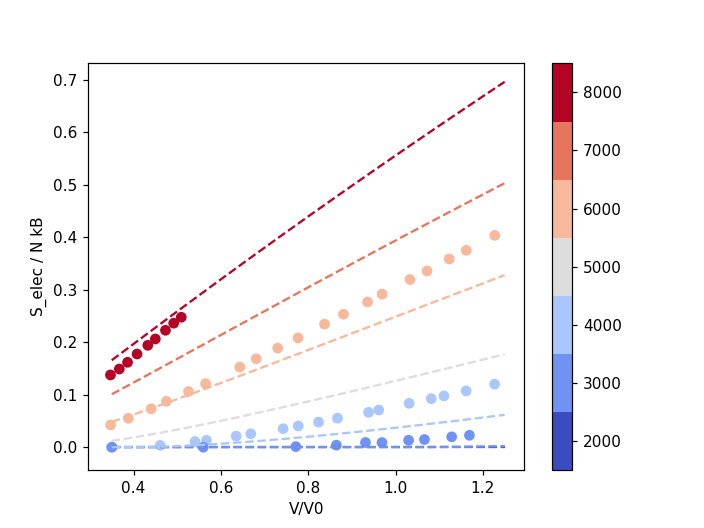

In [5]:
# Initial fit by hand

plt.figure()


T0_ref = 4000

cmap = plt.get_cmap('coolwarm',7)
plt.scatter(dat['V'],dat['S'],c=dat['T'],cmap=cmap)



param0 = [3000, -.3, 2.7e-4,+.6]

Tmod = [2000,3000,4000,5000,6000,7000,8000]

for T in Tmod:
    plt.plot(Vfrac, eval_S_elec(Vfrac,T,param0),'--',
             color=cmap((T-2000)/(8000-2000)))

plt.colorbar()
plt.clim(1500,8500)
plt.xlabel('V/V0')
plt.ylabel('S_elec / N kB')

In [6]:
def resid_S_elec(param, V=dat['V'], T=dat['T'], S=dat['S']):
    Smodel = eval_S_elec(V, T, param)
    resid_S = Smodel-S
    return resid_S

results = optimize.leastsq(resid_S_elec,param0)
paramf = results[0]

<IPython.core.display.Javascript object>


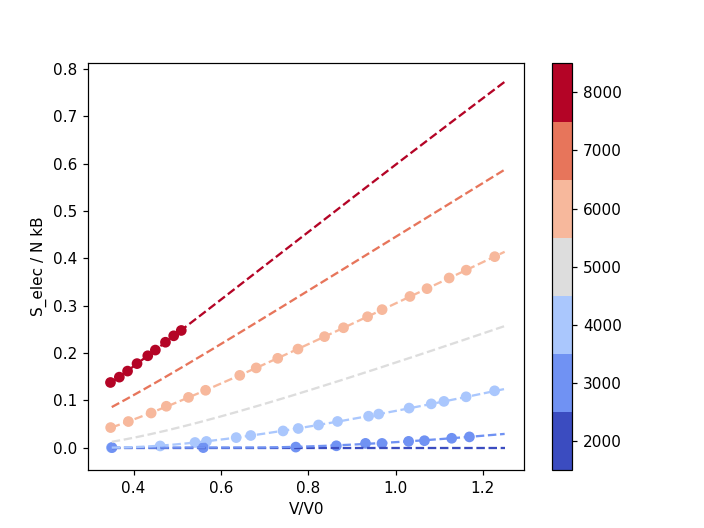

In [7]:

plt.figure()

plt.scatter(dat['V'],dat['S'],c=dat['T'],cmap=cmap)

Tmod = [2000,3000,4000,5000,6000,7000,8000]

for T in Tmod:
    plt.plot(Vfrac, eval_S_elec(Vfrac,T,paramf),'--',
             color=cmap((T-2000)/(8000-2000)))

plt.colorbar()
plt.clim(1500,8500)
plt.xlabel('V/V0')
plt.ylabel('S_elec / N kB')

In [8]:
eval_E_elec(Vfrac,2000,paramf)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

<IPython.core.display.Javascript object>


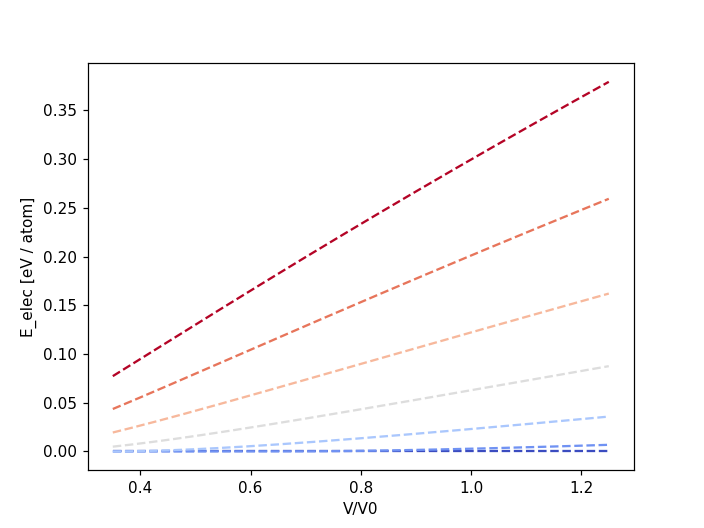

In [9]:
plt.figure()

for T in Tmod:
    plt.plot(Vfrac, eval_E_elec(Vfrac,T,paramf),'--',
             color=cmap((T-2000)/(8000-2000)))


plt.xlabel('V/V0')
plt.ylabel('E_elec [eV / atom]')

<IPython.core.display.Javascript object>


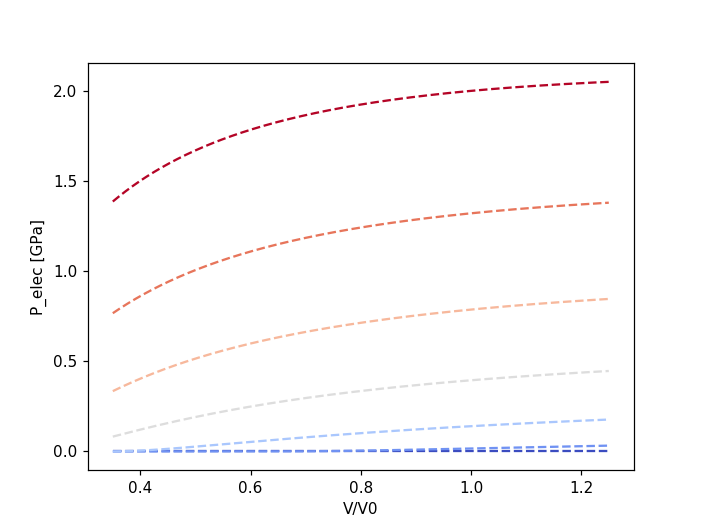

In [24]:
V0 = 12.97
plt.figure()

for T in Tmod:
    plt.plot(Vfrac, eval_P_elec(Vfrac,T,paramf, V0=V0),'--',
             color=cmap((T-2000)/(8000-2000)))


plt.xlabel('V/V0')
plt.ylabel('P_elec [GPa]')